<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
!pip install tensorflow

In [3]:
!pip3 install torchinfo

In [4]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf

import requests
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
url = "https://raw.githubusercontent.com/cristianEmel/nlp/refs/heads/main/Conversation.csv"
response = requests.get(url)
response.raise_for_status()
df = pd.read_csv(io.StringIO(response.text), sep=',', on_bad_lines='skip')
df = df.drop(df.columns[0], axis=1)
df.head(30)

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.
5,i've been good. i'm in school right now.,what school do you go to?
6,what school do you go to?,i go to pcc.
7,i go to pcc.,do you like it there?
8,do you like it there?,it's okay. it's a really big campus.
9,it's okay. it's a really big campus.,good luck with school.


In [7]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 60

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

for index, row in df.iterrows():
      # vamos separando el texto en "preguntas" (chat_in)
      # y "respuestas" (chat_out)
      chat_in = preprocess_text(row['question'])
      chat_out = preprocess_text(row['answer'])

      if pd.isna(chat_in) or pd.isna(chat_out):
        continue

      if len(chat_in) >= max_len or len(chat_out) >= max_len:
          continue

      input_sentence, output = chat_in, chat_out

      # output sentence (decoder_output) tiene <eos>
      output_sentence = output + ' <eos>'
      # output sentence input (decoder_input) tiene <sos>
      output_sentence_input = '<sos> ' + output

      input_sentences.append(input_sentence)
      output_sentences.append(output_sentence)
      output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 3477


In [8]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('im fine how about yourself',
 'im pretty good thanks for asking <eos>',
 '<sos> im pretty good thanks for asking')

In [9]:
MAX_VOCAB_SIZE = 10000

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [10]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 2254
Sentencia de entrada más larga: 16


In [11]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2310
Sentencia de salida más larga: 17


In [12]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 3477
encoder_input_sequences shape: (3477, 16)
decoder_input_sequences shape: (3477, 17)


In [13]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (3477, 17)


In [14]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 16
decoder_input_size: 17
Output dim 2311


In [15]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

Tamaño del conjunto de entrenamiento: 2782
Tamaño del conjunto de validacion: 695


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [16]:
import os
import gdown
import zipfile
import pickle

# URL of the .zip file on Google Drive (replace with your file's ID)
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip'

# Output path where you want to save the downloaded file
zip_output = 'fasttext.zip'

# Download the .zip file
if not os.path.exists(zip_output):
    gdown.download(url, zip_output, quiet=False)
else:
    print("File already downloaded.")

# Extract the .zip file
extract_dir = './fasttext_files/'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_output, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f"Extracted files to {extract_dir}")

# Assuming the .zip file contains a .vec file, find it
vec_file = None
for file_name in os.listdir(extract_dir):
    if file_name.endswith('.vec'):
        vec_file = os.path.join(extract_dir, file_name)
        break

if vec_file:
    print(f"Found .vec file: {vec_file}")

    # Load the .vec file and prepare it as a dictionary (word embeddings)
    embeddings = {}
    with open(vec_file, 'r', encoding='utf-8') as f:
        # Skip the header line that contains vocab size and embedding dimension
        first_line = f.readline().split()
        vocab_size, embedding_dim = int(first_line[0]), int(first_line[1])

        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = list(map(float, parts[1:]))
            embeddings[word] = vector

    # Save the embeddings as a .pkl file
    fasttext_pkl = 'fasttext.pkl'
    with open(fasttext_pkl, 'wb') as pkl_file:
        pickle.dump(embeddings, pkl_file)

    print(f"Saved embeddings to {fasttext_pkl}")
else:
    print("No .vec file found in the extracted .zip file.")

File already downloaded.
Extracted files to ./fasttext_files/
Found .vec file: ./fasttext_files/wiki-news-300d-1M-subword.vec
Saved embeddings to fasttext.pkl


In [17]:
import logging
import os
from pathlib import Path
import pickle
import numpy as np

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        index = np.arange(len(self.embeddings))

        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(list(self.embeddings.keys()), index)) # Modification: Use keys for word2idx
        self.idx2word = dict(zip(index, list(self.embeddings.keys()))) #

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)

        # Modification: Return embeddings based on words_idxs
        return np.array([self.embeddings.get(self.idx2word.get(idx, '-1'), np.zeros(self.N_FEATURES)) for idx in words_idxs])


    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [18]:
model_embeddings = FasttextEmbeddings()

In [19]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [20]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)

        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random
            # para ver en cada vuelta que técnica se aplica
            #input = top1

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

encoder_input = data_set[0:1][0]
decoder_input = data_set[0:1][1]
if cuda:
    encoder_input = encoder_input.cuda()
    decoder_input = decoder_input.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

summary(model, input_data=(encoder_input, decoder_input))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 17, 2311]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 16, 300]              (676,200)
│    └─LSTM: 2-2                         [1, 16, 128]              220,160
├─Decoder: 1-2                           [1, 2311]                 --
│    └─Embedding: 2-3                    [1, 1, 300]               693,300
│    └─LSTM: 2-4                         [1, 1, 128]               220,160
│    └─Linear: 2-5                       [1, 2311]                 298,119
│    └─Softmax: 2-6                      [1, 2311]                 --
├─Decoder: 1-3                           [1, 2311]                 (recursive)
│    └─Embedding: 2-7                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-8                         [1, 1, 128]               (recursive)
│    └─Linear: 2-9             

In [21]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))

        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    return {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }

In [22]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=20
                )

Epoch: 1/20 - Train loss 128.923 - Train accuracy 0.484 - Valid Loss 122.272 - Valid accuracy 0.562
Epoch: 2/20 - Train loss 121.678 - Train accuracy 0.591 - Valid Loss 122.127 - Valid accuracy 0.562
Epoch: 3/20 - Train loss 121.633 - Train accuracy 0.592 - Valid Loss 122.113 - Valid accuracy 0.563
Epoch: 4/20 - Train loss 121.617 - Train accuracy 0.593 - Valid Loss 122.110 - Valid accuracy 0.564
Epoch: 5/20 - Train loss 121.606 - Train accuracy 0.594 - Valid Loss 122.110 - Valid accuracy 0.564
Epoch: 6/20 - Train loss 121.608 - Train accuracy 0.593 - Valid Loss 122.112 - Valid accuracy 0.563
Epoch: 7/20 - Train loss 121.606 - Train accuracy 0.593 - Valid Loss 122.113 - Valid accuracy 0.563
Epoch: 8/20 - Train loss 121.600 - Train accuracy 0.594 - Valid Loss 122.120 - Valid accuracy 0.562
Epoch: 9/20 - Train loss 121.604 - Train accuracy 0.593 - Valid Loss 122.128 - Valid accuracy 0.562
Epoch: 10/20 - Train loss 121.588 - Train accuracy 0.594 - Valid Loss 122.122 - Valid accuracy 0.562

c:\Users\Emel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Emel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Emel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Emel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

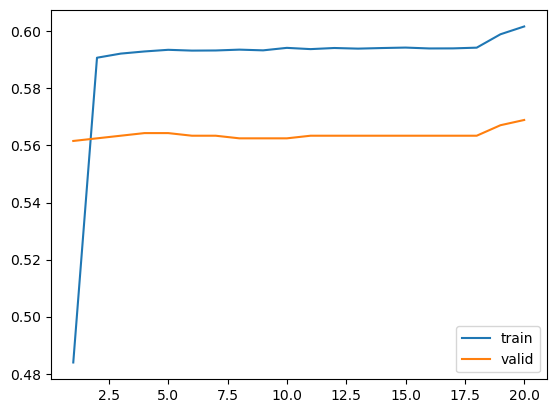

In [23]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [24]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
def response_sentence(input_test):
    print('Input:', input_test)
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
    print("Representacion en vector de tokens de ids", integer_seq_test)
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)
    encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

    # Se obtiene la salida del encoder (el estado oculto para el decoder)
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene la primera palabra de la secuencia de salida del decoder
    output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)


input_test = "Do you read?"
translation = response_sentence(input_test)
print('Response:', translation)


Input: Hi
Representacion en vector de tokens de ids [903]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 903]]
Response: i you i you i


No se vio una generacion satisfactoria de respuestas. Con distintas entradas, la respuesta era similar: i you i you.
Se probara reimplementando el metodo con uno funcion de seleccion de la palabra distinta, en este caso binomial

In [33]:
def response_sentence(input_test):
    print('Input:', input_test)
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
    print("Representacion en vector de tokens de ids", integer_seq_test)
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)
    encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        probs = F.softmax(output, dim=-1)  # Apply softmax to get probabilities
        top1 = torch.multinomial(probs, 1).view(-1, 1)  # Sample from the probabilities
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

input_test = "Do you read?"
translation = response_sentence(input_test)
print('Response:', translation)

Input: Do you read?
Representacion en vector de tokens de ids [8, 2, 375]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   8   2 375]]
Response: meant placed lately poker pets favorite teach thought kids upset driving anniversary stock screws cop mans smoker


Si bien, se vio cambio al ya no ser la misma palabra. No se vio correlacion entre ellos